In [1]:
import uuid
import json
from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, Literal

# Corrected LangChain imports
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.stores import BaseStore
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod


In [2]:

# --- 1. Define the Agent's State ---
# This TypedDict defines the structure of our agent's state.
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    personal_info_detected: str
    personal_info_extracted: str
    is_duplicate: str
    collected_memories: str

# --- 2. Setup LLM and Parsers ---
# Use the correct, non-deprecated ChatOllama class
llm = ChatOllama(model="llama3.2:latest", temperature=0)
json_parser = JsonOutputParser()

# --- 3. Node: Personal Info Classifier ---
# This node determines if the user's message contains personal information.

def personal_info_classifier(state: AgentState) -> AgentState:
    """Classifies if the last user message contains personal info."""
    last_message = state["messages"][-1].content

    # Final, most robust prompt for the classifier
    system_prompt = """
    You are a highly accurate classifier. Your sole task is to determine if the user's input CONTAINS a statement of personal information, preferences, or identifiable details.
    - IGNORE questions that ASK for information.
    
    Personal information includes:
    - Names (e.g., "My name is John")
    - Locations (e.g., "I live in Paris")
    - Hobbies or Interests (e.g., "I'm a big fan of The Lord of the Rings.")

    Your response MUST be a JSON object with a single key "score" and a value of either "Yes" or "No".
    
    --- EXAMPLES ---
    Input: "I like to play video games."
    Output: {{"score": "Yes"}}

    Input: "What time is it?"
    Output: {{"score": "No"}}
    
    Input: "What do you know about my hobbies?"
    Output: {{"score": "No"}}
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Here is the input: {question}"),
        ]
    )

    chain = prompt | llm | json_parser
    
    try:
        result = chain.invoke({"question": last_message})
        score = result.get("score", "No").strip()
        print(f"Classifier Result: {score}")
        state["personal_info_detected"] = score
    except Exception as e:
        print(f"Classifier failed with an error: {e}. Defaulting to 'No'.")
        state["personal_info_detected"] = "No"

    return state

# --- 4. Node: Personal Info Extractor ---
# This node extracts the identified personal information into a structured format.

def personal_info_extractor(state: AgentState) -> AgentState:
    """Extracts personal info from the user's message."""
    last_message = state["messages"][-1].content

    system_extractor = """
    You are an expert information extractor. From the user's message, extract any personal details like name, hobbies, interests, or location.
    Summarize the key personal fact in a concise phrase. For example:
    - "My name is Alice and I love hiking." -> "User's name is Alice and they love hiking."
    - "I'm a big fan of sci-fi movies." -> "User is a fan of sci-fi movies."
    - "I live in Tokyo." -> "User lives in Tokyo."

    If no personal information is found, output: "No personal info found."
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_extractor),
            ("human", "Extract personal information from: {message}"),
        ]
    )
    chain = prompt | llm

    extracted_info = chain.invoke({"message": last_message}).content.strip()
    print(f"Extracted Info: {extracted_info}")
    state["personal_info_extracted"] = extracted_info
    return state

# --- 5. Node: Duplicate Checker ---
# This node checks if the extracted information is already in our long-term memory.

def personal_info_duplicate_classifier(state: AgentState, store: BaseStore, user_id: str) -> AgentState:
    """Checks if the newly extracted info is a duplicate."""
    new_info = state.get("personal_info_extracted", "")
    if not new_info or "no personal info found" in new_info.lower() or "hobbies are unknown" in new_info.lower():
        state["is_duplicate"] = "Yes" # Treat as duplicate to avoid storing
        return state

    namespace = ("memories", user_id)
    existing_memories = store.search(namespace)
    old_info_list = [doc.value["data"] for doc in existing_memories]

    if not old_info_list:
        state["is_duplicate"] = "No" # If no old memories, it's definitely not a duplicate
        return state

    # A much more robust prompt for the de-duplicator
    system_deduper = """
    You are a meticulous duplicate-checking assistant. Your task is to determine if the "New Information" contains any genuinely new facts about the user that are not already present in the "Existing Memory".

    - If the "New Information" adds a new hobby, interest, name, location, or any other distinct fact, it is NOT a duplicate.
    - Rephrasing existing information IS a duplicate.

    --- EXAMPLES ---
    1. New Information: "User is a fan of The Lord of the Rings."
       Existing Memory: "User's name is Alex and they love playing chess."
       Reasoning: The new info adds a new interest (LOTR) which is not in the existing memory. This is new information.
       Output: {{"score": "No"}}

    2. New Information: "User likes to play the game of chess."
       Existing Memory: "User's name is Alex and they love playing chess."
       Reasoning: The hobby of playing chess is already known. This is a duplicate.
       Output: {{"score": "Yes"}}
    ---

    Now, analyze the following. Respond ONLY with a JSON object: {{"score": "Yes"}} for a duplicate or {{"score": "No"}} for new information.
    """
    human_template = """
    New Information:
    {new_info}

    Existing Memory:
    {old_info}

    Is the New Information a duplicate?
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_deduper),
            ("human", human_template),
        ]
    )
    chain = prompt | llm | json_parser

    try:
        result = chain.invoke({
            "new_info": new_info,
            "old_info": "\n".join(old_info_list)
        })
        is_duplicate = result.get("score", "Yes").strip()
        print(f"Duplicate Check Result: {is_duplicate}")
        state["is_duplicate"] = is_duplicate
    except Exception as e:
        print(f"Deduper failed with an error: {e}. Defaulting to 'Yes' (is a duplicate).")
        state["is_duplicate"] = "Yes"

    return state

# --- 6. Node: Memory Storer ---
# This node saves the new, unique information to our long-term store.

def personal_info_storer(state: AgentState, store: BaseStore, user_id: str) -> AgentState:
    """Stores new personal info in the long-term memory store."""
    extracted = state.get("personal_info_extracted")
    if extracted and "no personal info found" not in extracted.lower():
        namespace = ("memories", user_id)
        store.put(namespace, str(uuid.uuid4()), {"data": extracted})
        print(f"Stored new memory for user {user_id}: {extracted}")
    return state

# --- 7. Node: Retrieve and Log Memories ---
# This node retrieves all memories for the user to provide context to the final response.

def retrieve_and_log_memories(state: AgentState, store: BaseStore, user_id: str) -> AgentState:
    """Retrieves and logs all personal info from the store."""
    namespace = ("memories", user_id)
    results = store.search(namespace)
    memory_strs = [doc.value["data"] for doc in results]
    
    print("\n----- Logging Personal Memory -----")
    if memory_strs:
        for i, line in enumerate(memory_strs, 1):
            print(f"[Memory {i}] {line}")
    else:
        print("[Memory] No personal info stored yet.")
    print("-----------------------------------\n")
    
    state["collected_memories"] = "\n".join(memory_strs)
    return state

# --- 8. Node: The Main Model Call ---
# This is the final node that generates a response to the user.

def call_model(state: AgentState) -> AgentState:
    """Final LLM call that uses collected memories in the system message."""
    personal_info = state.get("collected_memories", "")
    
    system_msg_content = "You are a helpful assistant."
    if personal_info:
        system_msg_content += (
            "\nRemember the following information the user has shared with you:\n"
            f"{personal_info}"
        )

    # Prepend the system message to the conversation
    messages_with_system_prompt = [SystemMessage(content=system_msg_content)] + list(state["messages"])
    
    response = llm.invoke(messages_with_system_prompt)
    
    # Use add_messages to correctly append the new AIMessage
    state["messages"] = add_messages(state["messages"], [response])
    return state

# --- 9. Define Graph Edges and Routers ---

# Router to decide whether to extract info or skip to the end
def personal_info_router(state: AgentState) -> Literal["extract_personal_info", "retrieve_and_log_memories"]:
    return "extract_personal_info" if state["personal_info_detected"].lower() == "yes" else "retrieve_and_log_memories"

# Router to decide whether to store the info or skip if it's a duplicate
def personal_info_deduper_router(state: AgentState) -> Literal["personal_info_storer", "retrieve_and_log_memories"]:
    return "retrieve_and_log_memories" if state["is_duplicate"].lower() == "yes" else "personal_info_storer"


In [3]:

# --- 10. Build and Compile the Graph ---

# Define a unique user ID and the memory store
USER_ID = "user-123"
store = InMemoryStore()

# The checkpointer for managing short-term conversational memory
checkpointer = MemorySaver()

workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("personal_info_classifier", personal_info_classifier)
workflow.add_node("personal_info_extractor", personal_info_extractor)
# Use lambda functions to pass the store and user_id to the nodes that need them
workflow.add_node("personal_info_duplicate_classifier", lambda state: personal_info_duplicate_classifier(state, store, USER_ID))
workflow.add_node("personal_info_storer", lambda state: personal_info_storer(state, store, USER_ID))
workflow.add_node("retrieve_and_log_memories", lambda state: retrieve_and_log_memories(state, store, USER_ID))
workflow.add_node("call_model", call_model)

# Set the entry point
workflow.set_entry_point("personal_info_classifier")

# Add conditional edges
workflow.add_conditional_edges(
    "personal_info_classifier",
    personal_info_router,
    {
        "extract_personal_info": "personal_info_extractor",
        "retrieve_and_log_memories": "retrieve_and_log_memories",
    },
)
workflow.add_edge("personal_info_extractor", "personal_info_duplicate_classifier")

workflow.add_conditional_edges(
    "personal_info_duplicate_classifier",
    personal_info_deduper_router,
    {
        "personal_info_storer": "personal_info_storer",
        "retrieve_and_log_memories": "retrieve_and_log_memories",
    },
)

# Add remaining edges
workflow.add_edge("personal_info_storer", "retrieve_and_log_memories")
workflow.add_edge("retrieve_and_log_memories", "call_model")
workflow.add_edge("call_model", END)

# Compile the graph
graph = workflow.compile(checkpointer=checkpointer)


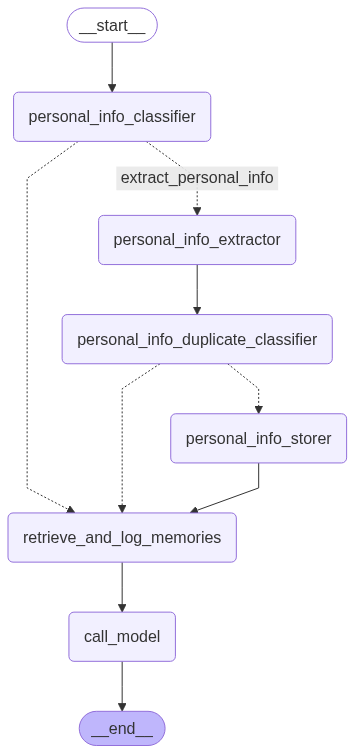

In [4]:

# --- 11. Visualize and Run the Graph ---

# Display the graph structure
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))


In [5]:

# Let's run a continuous conversation
# Use the same thread_id to maintain context
config = {"configurable": {"thread_id": "conversation-1"}}

# --- Turn 1: User introduces themselves ---
input1 = {"messages": [HumanMessage(content="Hi, my name is Alex and I love to play chess.")]}
response = graph.invoke(input=input1, config=config)
print("\nFinal Response 1:", response['messages'][-1].content)



# --- Turn 2: User adds more information ---
input2 = {"messages": [HumanMessage(content="I'm also a big fan of The Lord of the Rings.")]}
response = graph.invoke(input=input2, config=config)
print("\nFinal Response 2:", response['messages'][-1].content)



# --- Turn 3: User asks a question that relies on memory ---
input3 = {"messages": [HumanMessage(content="What are my hobbies?")]}
response = graph.invoke(input=input3, config=config)
print("\nFinal Response 3:", response['messages'][-1].content)


Classifier Result: Yes
Extracted Info: User's name is Alex and they love playing chess.
Stored new memory for user user-123: User's name is Alex and they love playing chess.

----- Logging Personal Memory -----
[Memory 1] User's name is Alex and they love playing chess.
-----------------------------------


Final Response 1: Hello Alex! It's great to meet you. I've heard that you're an avid chess player - do you have a favorite opening or strategy? Or perhaps you're looking for some tips or advice on improving your game? I'm here to help!
Classifier Result: Yes
Extracted Info: User is a fan of The Lord of the Rings.
Duplicate Check Result: No
Stored new memory for user user-123: User is a fan of The Lord of the Rings.

----- Logging Personal Memory -----
[Memory 1] User's name is Alex and they love playing chess.
[Memory 2] User is a fan of The Lord of the Rings.
-----------------------------------


Final Response 2: A fan of Middle-earth, eh? Which character is your favorite - is it 